# Emotion Classification and Intensity Estimation

This project is about taking tweets, classifying which emotion is present and then quantifying how intense that emotion is felt at the time of writing. Such a model has multiple use cases. For example, it may help businesses prioritise which product reviews to go over or which reviews to feature on the website.

It makes use of a slightly modified version of EmoInt, a package designed for affective computing like sentiment analysis, emotion classification, emotion intensity computing. See https://github.com/SEERNET/EmoInt

The network architecture first uses a pretrained transformer model to classify the tweet, and then an feedforward regressor MLP to quantify the intensity of the emotion. Feature preprocessing for the regressor is done via EmoInt.

The dataset used is from the WASSA-2017 Shared Task on Emotion Intensity (EmoInt) competition.

http://saifmohammad.com/WebPages/EmotionIntensity-SharedTask.html



## Setup EmoInt

In [ ]:
!git clone https://github.com/bobub/EmoInt.git

Cloning into 'EmoInt'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 409 (delta 49), reused 38 (delta 16), pack-reused 317
Receiving objects: 100% (409/409), 89.61 MiB | 55.38 MiB/s, done.
Resolving deltas: 100% (198/198), done.


In [ ]:
%cd EmoInt/

/content/EmoInt


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating EmoInt.egg-info
writing EmoInt.egg-info/PKG-INFO
writing dependency_links to EmoInt.egg-info/dependency_links.txt
writing requirements to EmoInt.egg-info/requires.txt
writing top-level names to EmoInt.egg-info/top_level.txt
writing manifest file 'EmoInt.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'

writing manifest file 'EmoInt.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/emoint
copying emoint/__init__.py -> build/lib/emoint
creating build/lib/emoint/featurizers
copying emoint/featurizers/bing_liu_sentiment_featurizer.py -> build/lib/emoint/featurizers
copying emoint/featurizers/sentistrength.py -> build/lib/emoint/featurizers
copying emoint/featurizers/nrc_emotion_wordlevel_featurizer.py -> build/lib/emoint/featurizers
copying emoint/featurizers/utils.py -> build/lib/emoint/featurizers
co

In [ ]:
!python -m unittest discover -v

test_amean_ensemble (emoint.tests.test_ensembles.TestEnsembles) ... ok
test_gmean_ensemble (emoint.tests.test_ensembles.TestEnsembles) ... ok
test_vote_ensemble (emoint.tests.test_ensembles.TestEnsembles) ... ok
test_featurizer (emoint.tests.test_featurizers.TestAFINNValenceFeaturizer) ... ok
test_featurizer (emoint.tests.test_featurizers.TestBingLiuFeaturizer) ... ok
test_featurizer (emoint.tests.test_featurizers.TestEdinburghEmbeddingFeaturizer) ... ok
test_featurizer (emoint.tests.test_featurizers.TestEmojiEmbeddingFeaturizer) ... ok
test_featurizer (emoint.tests.test_featurizers.TestEmojiSentimentRanking) ... ok
test_featurizer (emoint.tests.test_featurizers.TestLIWCFeaturizer) ... ok
test_featurizer (emoint.tests.test_featurizers.TestMPQAEffectFeaturizer) ... ok
test_featurizer (emoint.tests.test_featurizers.TestNRCAffectIntensityFeaturizer) ... ok
test_featurizer (emoint.tests.test_featurizers.TestNRCEmotionFeaturizer) ... ok
test_featurizer (emoint.tests.test_featurizers.TestNRC

## Imports

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib  inline
from emoint.featurizers.emoint_featurizer import EmoIntFeaturizer
import tensorflow as tf
from google.colab import files


## Data Visualised 

http://saifmohammad.com/WebPages/TweetEmotionIntensity-dataviz.html

## Download Data

In [ ]:
# get test data as well
!wget http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/anger-ratings-0to1.test.gold.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/fear-ratings-0to1.test.gold.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/joy-ratings-0to1.test.gold.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/sadness-ratings-0to1.test.gold.txt

--2020-12-20 12:29:49--  http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/anger-ratings-0to1.test.gold.txt
Resolving saifmohammad.com (saifmohammad.com)... 192.185.17.122
Connecting to saifmohammad.com (saifmohammad.com)|192.185.17.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87266 (85K) [text/plain]
Saving to: ‘anger-ratings-0to1.test.gold.txt’

anger-ratings-0to1. 100%[===================>]  85.22K  --.-KB/s    in 0.09s   

2020-12-20 12:29:49 (914 KB/s) - ‘anger-ratings-0to1.test.gold.txt’ saved [87266/87266]

--2020-12-20 12:29:49--  http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/fear-ratings-0to1.test.gold.txt
Resolving saifmohammad.com (saifmohammad.com)... 192.185.17.122
Connecting to saifmohammad.com (saifmohammad.com)|192.185.17.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114255 (112K) [text/plain]
Saving to: ‘fear-ratings-0to1.test.gold.txt’

fear-ratings-0to1.t 100%[===================>]

# Emotion Classification

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 12.0MB/s 
     |████████████████████████████████| 890kB 54.4MB/s 
     |████████████████████████████████| 2.9MB 53.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=d04d00097f3ad6380614b1204fecc7a09cc96b2eb5fabb2e437f3c24bea2ecf6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# SOME UTILITY FUNCTIONS

# get data
def get_data(path):
    df = pd.read_csv(path, header=None, sep='\t')
    tweets = df[1]
    emotion = df[2]
    intensities = df[3]
    # tokenise
    # X = tokenizer(text=pd.Series.tolist(tweets), truncation=True, padding=True)
    X, y, z = pd.Series.tolist(tweets), np.array(intensities, dtype=float), np.array(emotion)
    return X, y, z

def emotion_label(emotion):
  # converts emotions into numerical labels
  result = []
  for e in emotion:
    #print(e)
    if e=='anger':
      result.append(0)
    if e=='joy':
      result.append(1)
    if e=='fear':
      result.append(2)
    if e=='sadness':
      result.append(3)
  result = np.array(result, dtype=int)
  return result

def prep_data(all_paths):
  # join all datapaths into single dataset, tokenise tweets and convert emotions to num
  tweets, intensities, emotion = [], [], []
  # get data
  for path in all_paths:
    X,y,z = get_data(path)
    tweets.append(X)
    intensities.append(y)
    emotion.append(z)
  # join data
  tweets, intensities, emotion = np.concatenate(tweets, axis=0), np.concatenate(intensities, axis=0), np.concatenate(emotion, axis=0)
  # turn categories into numbers
  num_emotion = emotion_label(emotion)
  return tweets, intensities, num_emotion

# to access results later
emo_dict = {'0':'anger', '1':'joy', '2':'fear', '3':'sadness'}


In [ ]:
# prep data
data_paths = ['/content/EmoInt/emoint/resources/emoint/anger-ratings-0to1.train.txt',
              '/content/EmoInt/emoint/resources/emoint/fear-ratings-0to1.train.txt',
              '/content/EmoInt/emoint/resources/emoint/joy-ratings-0to1.train.txt',
              '/content/EmoInt/emoint/resources/emoint/sadness-ratings-0to1.train.txt',
              '/content/EmoInt/anger-ratings-0to1.test.gold.txt',
              '/content/EmoInt/fear-ratings-0to1.test.gold.txt',
              '/content/EmoInt/joy-ratings-0to1.test.gold.txt',
              '/content/EmoInt/sadness-ratings-0to1.test.gold.txt',
              '/content/EmoInt/emoint/resources/emoint/joy-ratings-0to1.dev.gold.txt',
              '/content/EmoInt/emoint/resources/emoint/anger-ratings-0to1.dev.gold.txt',
              '/content/EmoInt/emoint/resources/emoint/fear-ratings-0to1.dev.gold.txt',
              '/content/EmoInt/emoint/resources/emoint/sadness-ratings-0to1.dev.gold.txt']

tweets, intensities, num_emotion = prep_data(data_paths)


In [ ]:
# convert to list
tweets = tweets.tolist()
intensities = intensities.tolist()
num_emotion = num_emotion.tolist()

In [ ]:
# separate into train,dev,test

# separate data into train, dev and test sets
from sklearn.model_selection import train_test_split
# 80% train 20% test
train_texts, test_texts, train_labels, test_labels, train_intensities, test_intensities = train_test_split(tweets, num_emotion, intensities, test_size=.2)
# 20% of train is dev
train_texts, dev_texts, train_labels, dev_labels, train_intensities, dev_intensities = train_test_split(train_texts, train_labels, train_intensities, test_size=.2)


In [ ]:
# tokenise
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
dev_encodings = tokenizer(dev_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
# create tf datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
dev_dataset = tf.data.Dataset.from_tensor_slices((
    dict(dev_encodings),
    dev_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))


In [ ]:
# use pretrained DistilBERT and fit
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16,
          validation_data=dev_dataset.shuffle(1000).batch(16))

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fdd45befe58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fdd45befe58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


284/284 [==============================] - ETA: 0s - loss: 1.0131 - accuracy: 0.5332

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


284/284 [==============================] - 68s 130ms/step - loss: 1.0120 - accuracy: 0.5338 - val_loss: 0.4420 - val_accuracy: 0.8452
Epoch 2/3
284/284 [==============================] - 37s 130ms/step - loss: 0.3164 - accuracy: 0.8891 - val_loss: 0.4159 - val_accuracy: 0.8487
Epoch 3/3
284/284 [==============================] - 36s 128ms/step - loss: 0.2007 - accuracy: 0.9318 - val_loss: 0.4932 - val_accuracy: 0.8478


In [ ]:
# save and download model
save_directory = "/content/saved_models" # change this to your preferred location
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
# files.download('/content/saved_models/tf_model.h5')

('/content/saved_models/tokenizer_config.json',
 '/content/saved_models/special_tokens_map.json',
 '/content/saved_models/vocab.txt',
 '/content/saved_models/added_tokens.json')

In [ ]:
# load model and use for some predictions
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /content/saved_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/saved_models and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# show 10 examples of emotion classification model on unseen test data
for i in range(10):
  test_text = test_texts[i]
  predict_input = loaded_tokenizer.encode(test_text,
                                  truncation=True,
                                  padding=True,
                                  return_tensors="tf")

  output = loaded_model(predict_input)[0]
  prediction_value = tf.argmax(output, axis=1).numpy()[0]

  print('Tweet: ',test_text)
  print('Classified Emotion: ',emo_dict[str(prediction_value)])
  print('Actual Emotion: ', emo_dict[str(test_labels[i])])

Tweet:  the Lord turn his face toward you and give you peace. Numbers 6:26 #truth #trust #promise #calm #justice #great #mighty #protected #delight
Classified Emotion:  joy
Actual Emotion:  joy
Tweet:  Last night my stomach was hurting and today I have a horrible headache. I can never win
Classified Emotion:  anger
Actual Emotion:  fear
Tweet:  @KimLy resent
Classified Emotion:  anger
Actual Emotion:  anger
Tweet:  Swear I got the most playful ass bf ever 😂🙄
Classified Emotion:  joy
Actual Emotion:  joy
Tweet:  Shoutout to the drunk man on the bus who pissed in a bottle and on the seats 
Classified Emotion:  anger
Actual Emotion:  sadness
Tweet:  I miss my naivety and blind optimism
Classified Emotion:  joy
Actual Emotion:  joy
Tweet:  Trying to think positive, and not let this situation discourage me ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
Classified Emotion:  sadness
Actual Emotion:  sadness
Tweet:  my bls depress the blake
Classified Emotion:  sadne

In [ ]:
# final model evaluation
print("Evaluate")
result = model.evaluate(test_dataset.batch(16))
dict(zip(model.metrics_names, result))

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Evaluate
89/89 [==============================] - 5s 46ms/step - loss: 0.4208 - accuracy: 0.8578


{'accuracy': 0.8578465580940247, 'loss': 0.4208027422428131}

# Combined Model - Incomplete


In [ ]:
# feature engineering

from emoint.featurizers.emoint_featurizer import EmoIntFeaturizer
from nltk.tokenize import TweetTokenizer

featurizer = EmoIntFeaturizer()
tokenizer = TweetTokenizer()

def get_features(tweets):
  encodings = []
  for t in tweets:
    tokens = tokenizer.tokenize(t)
    features = featurizer.featurize(text=t, tokenizer=tokenizer)
    encodings.append(features)
  feature_names = featurizer.features
  # encodings 
  return np.array(encodings), feature_names


In [ ]:
def plot_fig(f, regr, labels, title, num, subnum, cnt):
    ax = f.add_subplot(subnum)
    f.subplots_adjust(hspace=.4)
    if subnum % 2 == 0:
        ax.yaxis.tick_right()
    indices = np.argsort(regr.feature_importances_)[-10:]
    plt.barh(np.arange(len(indices)), regr.feature_importances_[indices], color=colors[cnt])
    plt.yticks(np.arange(len(indices)) + 0.75/2 , np.array(labels)[indices])
    plt.xlabel('Relative importance')
    plt.title(title)

def plot_feat(tweets, tweets_features, feature_names):
  fig = plt.figure(figsize=(16,8))
  for i in range(6):
    idx = np.argsort(tweet_features[i])[-10:]
    plt.subplot(3,2,i+1)
    plt.barh(np.arange(len(idx)), tweet_features[i][idx])
    plt.yticks(np.arange(len(idx)) + 0.75/2, np.array(feature_names)[idx])
    plt.xlabel('Relative importance')
    plt.title(tweets[i])
  plt.tight_layout()

from matplotlib import pyplot as plt


In [ ]:
# get data
tweets, intensities, num_emotion = prep_data(data_paths)

In [ ]:
tweet_features, feature_names = get_features(tweets)

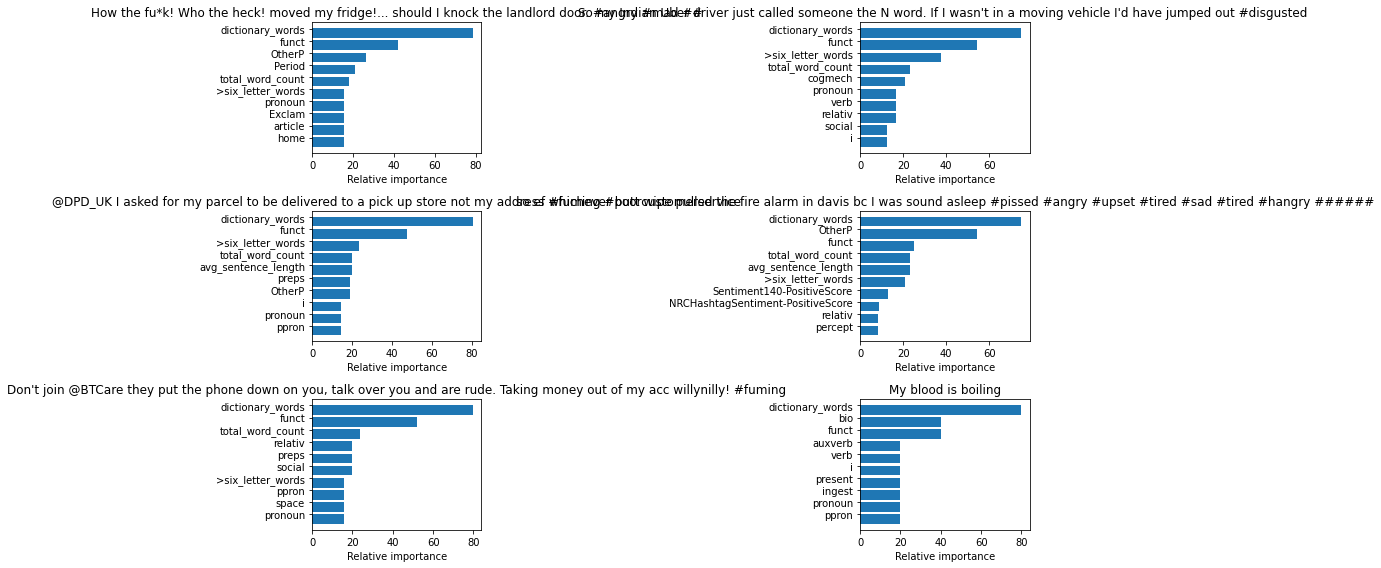

In [ ]:
# trying to show which tweet_features score highly in each tweet according to the different featurizers from EmoInt
plot_feat(tweets, tweet_features, feature_names)

In [ ]:
idx = np.arange(len(tweets))

# separate into train,dev,test according to idx
from sklearn.model_selection import train_test_split
# 80% train 20% test
train_idx, test_idx = train_test_split(idx, test_size=.2)
# 20% of train is dev
train_idx, dev_idx = train_test_split(train_idx, test_size=.2)

In [ ]:
train_tweets, test_tweets = tweets[list(train_idx)], tweets[list(test_idx)]
train_tweet_feat, test_tweet_feat = tweet_features[list(train_idx)], tweet_features[list(test_idx)]
train_emotion, test_emotion = num_emotion[list(train_idx)], num_emotion[list(test_idx)]
train_intensities, test_intensities = intensities[list(train_idx)], intensities[list(test_idx)]

In [ ]:
type(test_tweet_feat)

numpy.ndarray

In [ ]:
# tokenise tweets
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_tweets.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_tweets.tolist(), truncation=True, padding=True)

In [ ]:
# create tf datasets for BERT classification
train_BERT_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_emotion.tolist()
))
test_BERT_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_emotion.tolist()
))

# create tf datasets for MLP intensity estimation
train_MLP_dataset = tf.data.Dataset.from_tensor_slices((
    train_tweet_feat.tolist(),
    train_intensities.tolist()
))
test_MLP_dataset = tf.data.Dataset.from_tensor_slices((
    test_tweet_feat.tolist(),
    test_intensities.tolist()
))


In [ ]:
# Define a model using functional API
# 2 inputs, 2 outputs

from tensorflow import keras
from tensorflow.keras import layers

# 1. Define inputs
input_BERT = keras.Input(shape=(None,), name='tokenised_tweets')
input_MLP = keras.Input(shape=(np.shape(test_tweet_feat)[1],), name='tweet_feats')
inputs = [input_BERT, input_MLP]

# 2. Setup hidden layers - I've written pseudocode because I don't know the proper format yet
# https://www.tensorflow.org/guide/keras/functional
# 2a. BERT layer
# how to use a model as a layer?
# I think we need to create a custom layer BERT sequence classification class, like in:
# https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
BERT_layer = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(np.unique(num_emotion)))
output_BERT = # BERT Layer applied

# 2b. join bert output with tweet_features
# joined = input_MLP + output_BERT 

# 2c. Fully connected layers (mlp regressor)
dense = layers.Dense(# joined)
dense2 = layers.Dense(#shape )(dense)
output_MLP = layers.Dense(# shape)(dense2)


# 3 Outputs
outputs = [output_BERT, output_MLP]


# Regression Model

Takes feature and emotion as input and the intensity as target. We will train this model and look at the accuracy. If we are able to achieve good results, we can then combine this with the earlier model using keras.Sequential APIs and test end-to-end.

In [ ]:
# use pretrained DistilBERT and fit for regression this time
from transformers import TFDistilBertModel

# num_labels = 1 pools the output for regression of values between 0 and 1
model_reg = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

model_reg.trainable = False

input_ids = tf.keras.Input(shape=(None, ),dtype='int32', name="input_ids")
attention_mask = tf.keras.Input(shape=(None, ), dtype='int32', name="attention_mask")

embeddings = model_reg([input_ids, attention_mask])
hidden_states = embeddings[0]# get output_hidden_states

input_emotion = tf.keras.layers.Input(shape=(1,1, ), dtype='float32', name="emotion")

mid = tf.keras.layers.Dense(1)(hidden_states)
concat = tf.keras.layers.Concatenate(axis=1)([mid, input_emotion])
output = tf.keras.layers.Dense(128)(concat)
fin_output = tf.keras.layers.Dense(1, activation="sigmoid")(output)

model_final = tf.keras.models.Model(inputs = [input_ids, attention_mask, input_emotion], outputs = fin_output)

model_final.summary()

model_final.compile(tf.keras.optimizers.SGD(lr=5e-5), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cach

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_86 (TFDist TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_82 (Dense)                (None, None, 1)      769         tf_distil_bert_model_86[0]

## Prepare Data for Model

In [ ]:
dict_train = dict(train_encodings)
dict_train["emotion"] = train_labels
dict_dev = dict(dev_encodings)
dict_dev["emotion"] = dev_labels
dict_test = dict(test_encodings)
dict_test["emotion"] = test_labels

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict_train,
    train_intensities
))

dev_dataset = tf.data.Dataset.from_tensor_slices((
    dict_dev,
    dev_intensities,
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict_test,
    test_intensities,
))

## Fit the model

In [ ]:
tf.config.run_functions_eagerly(True)

model_final.fit(train_dataset.shuffle(1000).batch(16),  epochs=3, batch_size=16, validation_data=dev_dataset.batch(16))

Epoch 1/3
284/284 [==============================] - 53s 187ms/step - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 2/3
284/284 [==============================] - 53s 188ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 3/3
284/284 [==============================] - 53s 186ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.0383 - val_mean_squared_error: 0.0383


## Evaluate on test dataset

In [ ]:
# Final model evaluation
print("Evaluate")
result = model_final.evaluate(test_dataset.batch(16))
dict(zip(model_final.metrics_names, result))

Evaluate
89/89 [==============================] - 6s 73ms/step - loss: 0.0376 - mean_squared_error: 0.0376


{'loss': 0.037622105330228806, 'mean_squared_error': 0.037622105330228806}

## Example predictions

In [ ]:
example_out = model_final.predict(test_dataset.batch(16))
processed_output = np.mean(example_out, axis=1)


In [ ]:
processed_output.shape

(1421, 1)

In [ ]:
for i in range(10):
  test_text = test_texts[i]
  print('Tweet: ',test_text)
  print('Emotion: ', test_labels[i])
  print('Predicted Intensity: ', processed_output[i][0])
  print('Actual Intensity: ', test_intensities[i])

Tweet:  @kerrybowen_ you have anger issues!
Emotion:  0
Predicted Intensity:  0.4954033
Actual Intensity:  0.5
Tweet:  @Bhavnay that, i dont mind too much. smoother, thicker texture. makes it more hearty. also, im glad iced coffee is a thing in the uk now.
Emotion:  1
Predicted Intensity:  0.49360406
Actual Intensity:  0.5
Tweet:  @comcast you charge 150 extra for sending someone out and your cable service still doesn't work. That's robbery.  #cable #horrible #service
Emotion:  2
Predicted Intensity:  0.4919322
Actual Intensity:  0.33299999999999996
Tweet:  Having a blast playing games and hearing testimonies at Pastor Jeremy's house #fellowship #food #laughter #praise #gospel #coffey1617
Emotion:  1
Predicted Intensity:  0.49680224
Actual Intensity:  0.8079999999999999
Tweet:  @xBladeMania 'I didn't see them???' huff.
Emotion:  0
Predicted Intensity:  0.49720165
Actual Intensity:  0.41700000000000004
Tweet:  Every day I think my #house 🏡 is #burning 🔥 but it's always just my neighbor 